<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/058_Graph_Neural_Networks_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/58_Graph_Neural_Networks_GNN.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🕸️ GNN: Gdy dane nie są tabelką (Graph Neural Networks)

CNN przesuwa filtr po pikselach. Ale co, jeśli Twoje dane nie mają "góry" i "dołu"? Co jeśli to sieć społecznościowa?

Używamy Grafów:
*   **Węzły (Nodes):** Ludzie, Atomy. (Mają swoje cechy $X$).
*   **Krawędzie (Edges):** Relacje (Znajomość, Wiązanie chemiczne). Reprezentujemy je macierzą sąsiedztwa $A$.

**Idea Message Passing (Przekazywanie Wiadomości):**
W każdej rundzie każdy węzeł "rozmawia" ze swoimi sąsiadami.
1.  Pobiera informacje od sąsiadów.
2.  Uśrednia je.
3.  Aktualizuje swoją wiedzę.

Wzór na prostą warstwę grafową (GCN):
$$ H_{new} = \text{ReLU}(A \times H \times W) $$
Gdzie $A$ to macierz połączeń (kto z kim gada), $H$ to cechy, a $W$ to wagi sieci.

--- MACIERZ SĄSIEDZTWA (Adjacency Matrix) ---
tensor([[0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.]])


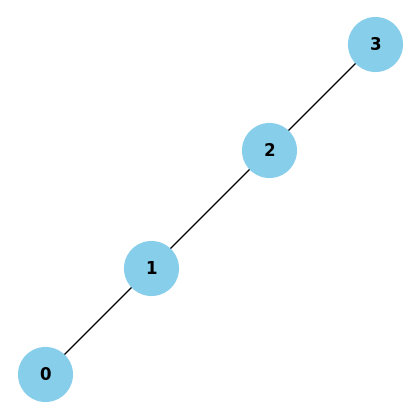

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx # Do rysowania grafów

# 1. TWORZYMY MAŁY GRAF (Społeczność 4 osób)
# 0 zna 1
# 1 zna 0 i 2
# 2 zna 1 i 3
# 3 zna 2 (Łańcuch 0-1-2-3)

adj_matrix = torch.tensor([
    [0, 1, 0, 0], # Osoba 0
    [1, 0, 1, 0], # Osoba 1
    [0, 1, 0, 1], # Osoba 2
    [0, 0, 1, 0]  # Osoba 3
], dtype=torch.float32)

print("--- MACIERZ SĄSIEDZTWA (Adjacency Matrix) ---")
print(adj_matrix)

# Wizualizacja
G = nx.from_numpy_array(adj_matrix.numpy())
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_weight='bold')
plt.show()

## Problem: Brak tożsamości

Spójrz na macierz $A$. Na przekątnej są same zera.
Jeśli pomnożymy cechy przez tę macierz ($A \times X$), to każdy węzeł otrzyma sumę cech sąsiadów, ale **zapomni o sobie samym**!

**Rozwiązanie: Self-Loop (Pętla Zwrotna).**
Dodajemy do macierzy Macierz Jednostkową ($I$). To tak, jakby każdy był swoim własnym sąsiadem.
$$ \tilde{A} = A + I $$

In [2]:
# Dodajemy Self-Loop (Jedynki na przekątnej)
I = torch.eye(4)
A_hat = adj_matrix + I

print("--- MACIERZ Z SELF-LOOP ---")
print(A_hat)
print("(Teraz na przekątnej są jedynki - węzeł słucha też samego siebie)")

--- MACIERZ Z SELF-LOOP ---
tensor([[1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.]])
(Teraz na przekątnej są jedynki - węzeł słucha też samego siebie)


## Cechy Węzłów (Features)

Każda osoba w grafie ma jakieś cechy (np. [Wiek, Zarobki]).
Niech każdy węzeł ma na start 2 cechy.

In [3]:
# Cechy początkowe (Input Features)
# 4 węzły, 2 cechy każdy
X = torch.tensor([
    [10, 1], # Osoba 0 (Bogata, Młoda)
    [5,  2], # Osoba 1
    [2,  5], # Osoba 2
    [1, 10]  # Osoba 3 (Biedna, Stara)
], dtype=torch.float32)

print("--- CECHY PRZED KOMUNIKACJĄ ---")
print(X)

--- CECHY PRZED KOMUNIKACJĄ ---
tensor([[10.,  1.],
        [ 5.,  2.],
        [ 2.,  5.],
        [ 1., 10.]])


## Implementacja Warstwy GCN (Od zera)

Zbudujemy warstwę, która wykonuje operację:
$$ Output = \text{ReLU}( \tilde{A} \times X \times W ) $$

1.  $\tilde{A} \times X$: Agregacja (Suma cech sąsiadów i swoich).
2.  $\times W$: Transformacja (Zwykła sieć neuronowa, uczy się wag).
3.  $\text{ReLU}$: Aktywacja.

*Uwaga: W profesjonalnych GCN dodaje się jeszcze normalizację stopnia (dzielenie przez liczbę sąsiadów), tutaj to pominiemy dla przejrzystości.*

In [4]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Macierz Wag (Transformacja liniowa)
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, adj):
        # KROK 1: Agregacja (Sąsiedzi przesyłają wiadomości)
        # Mnożenie macierzy A * X sumuje cechy sąsiadów
        # [4x4] @ [4x2] -> [4x2]
        aggregated = torch.matmul(adj, x)
        
        # KROK 2: Transformacja (Uczenie)
        output = self.linear(aggregated)
        
        # KROK 3: Aktywacja
        return torch.relu(output)

# Inicjalizacja: Wejście 2 cechy -> Wyjście 2 cechy
# Ustawiamy wagi na sztywno (Jedynki), żebyśmy widzieli czystą matematykę, a nie losowość
gcn = GCNLayer(2, 2)
with torch.no_grad():
    gcn.linear.weight.fill_(1.0) 

print("Warstwa GCN gotowa.")

Warstwa GCN gotowa.


In [5]:
# PRZEPŁYW DANYCH
with torch.no_grad():
    new_features = gcn(X, A_hat)

print("--- CECHY PO 1 RUNDZIE KOMUNIKACJI ---")
print(new_features)

print("-" * 30)
print("ANALIZA OSOBY 0:")
print(f"Było: {X[0].tolist()} (Bogata, Młoda)")
print("Sąsiad (Osoba 1): [5, 2]")
print(f"Suma (Ona + Sąsiad): [10+5, 1+2] = [15, 3]")
print(f"Wynik sieci (Wagi=1): [15+3, 15+3] = [18, 18]")
print(f"W tabeli widzisz: {new_features[0].tolist()}")
print("Węzeł 0 'wchłonął' trochę biedy od węzła 1!")

--- CECHY PO 1 RUNDZIE KOMUNIKACJI ---
tensor([[18., 18.],
        [25., 25.],
        [25., 25.],
        [18., 18.]])
------------------------------
ANALIZA OSOBY 0:
Było: [10.0, 1.0] (Bogata, Młoda)
Sąsiad (Osoba 1): [5, 2]
Suma (Ona + Sąsiad): [10+5, 1+2] = [15, 3]
Wynik sieci (Wagi=1): [15+3, 15+3] = [18, 18]
W tabeli widzisz: [18.0, 18.0]
Węzeł 0 'wchłonął' trochę biedy od węzła 1!


## 🧠 Podsumowanie: Świat to relacje

Właśnie zobaczyłeś, jak działa **Message Passing**.
Po jednej warstwie, węzeł 0 wie coś o węźle 1.
Po dwóch warstwach, węzeł 0 będzie wiedział coś o węźle 2 (bo 2 przekazał info do 1, a 1 przekazał do 0).

**Zastosowania:**
1.  **Chemia (AlphaFold):** Atomy to węzły, wiązania to krawędzie. GNN przewiduje, czy lek zadziała.
2.  **Mapy Google:** Skrzyżowania to węzły, drogi to krawędzie. GNN przewiduje czas dojazdu (ETA), analizując "korki u sąsiadów".
3.  **Rekomendacje (Pinterest):** Użytkownik i Produkt to węzły w grafie. GNN przewiduje nowe krawędzie ("Kupi").